In [ ]:
import pandas as pd
import xgboost as xgb
import sklearn
import time
import os
import boto3
import sagemaker
import json
import os
import xgboost
import numpy as np
import mlflow
from sagemaker.remote_function import remote
import time
import functools
import urllib
import urllib.request
import matplotlib.pyplot as plt
import seaborn as sbn
import matplotlib.pyplot as plt
import os
import joblib
from sagemaker.workflow.execution_variables import ExecutionVariables
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from sagemaker.remote_function import remote
import mlflow
import pandas as pd
from time import gmtime, strftime
from sagemaker.s3 import S3Downloader
import subprocess
from sagemaker.serve import CustomPayloadTranslator, ModelServer
from sagemaker.serve.builder.model_builder import ModelBuilder
from sagemaker.serve.builder.schema_builder import SchemaBuilder
from sagemaker.serve import InferenceSpec
from sagemaker.pipeline import PipelineModel
from sagemaker.utils import unique_name_from_base
from sagemaker import get_execution_role
from sagemaker.image_uris import retrieve as get_image_uri
import io
import pandas as pd
import numpy as np
import os
import joblib
import xgboost


In [ ]:
os.environ["AWS_ACCESS_KEY_ID"]="Your AWS_ACCESS_KEY_ID"
os.environ["AWS_SECRET_ACCESS_KEY"]="Your AWS_SECRET_ACCESS_KEY"
os.environ["SAGEMAKER_ROLE"]="your SAGEMAKER_ROLE"

In [1]:
# sagemaker.get_execution_role()

In [ ]:
AWS_ACCESS_KEY_ID = os.environ.get("AWS_ACCESS_KEY_ID")
AWS_SECRET_ACCESS_KEY = os.environ.get("AWS_SECRET_ACCESS_KEY")
region_name = "us-east-1"
role = os.environ.get("SAGEMAKER_ROLE")
AWS_ACCESS_KEY_ID, AWS_SECRET_ACCESS_KEY, role

In [ ]:
boto_session = boto3.Session(region_name=region_name,
                             aws_access_key_id=AWS_ACCESS_KEY_ID,
                             aws_secret_access_key=AWS_SECRET_ACCESS_KEY)
sm_session = sagemaker.Session(boto_session=boto_session)
sm_client = boto_session.client("sagemaker")
bucket_name = "sagemaker07272025"
project_prefix = "amzn"
bucket_prefix = f"s3://{bucket_name}/{project_prefix}"
mlflow_artifact_path = f"s3://{bucket_prefix}/mlflow"


In [16]:
# def create_mlflow_tracking_server(server_name: str):
#     response = sm_client.create_mlflow_tracking_server(
#         TrackingServerName=server_name,
#         ArtifactStoreUri=mlflow_artifact_path,
#         RoleArn=role,
#     )
#     print(f"Started creation of MLflow Tracking Server {server_name}")
#     print(f"ARN: {response['TrackingServerArn']}")
#     return response

In [17]:
# def log_execution_time(func):
#     @functools.wraps(func)
#     def wrapper(*args, **kwargs):
#         start = time.time()
#         result = func(*args, **kwargs)
#         end = time.time()
#         duration = end - start
#         print(f"Function '{func.__name__}' executed in {duration:.4f} seconds")
#         return result
#     return wrapper


In [18]:
# def wait_for_mlflow_server(server_name: str, timeout=1600):
#     start = time.time()
#     while True:
#         response = sm_client.describe_mlflow_tracking_server(TrackingServerName=server_name)
#         status = response["TrackingServerStatus"]
#         print(f"[{int(time.time() - start)}s] Status: {status}")
#         if status == "Created":
#             print("MLflow server is ready.")
#             return response
#         elif status in ["Failed", "Deleting"]:
#             raise Exception(f"Server creation failed with status : {status}")
#         if time.time() - start > timeout:
#             raise TimeoutError("Timeout while waiting for MLflow server creation.")
#         time.sleep(10)

# mlflow_server_name = "sagemaker-cicd-poc"
# # mlflow_arn = create_mlflow_tracking_server(mlflow_server_name)
# mlflow_arn = "arn:aws:sagemaker:us-east-1:395435558728:mlflow-tracking-server/sagemaker-cicd-poc"
# mlflow_info = wait_for_mlflow_server(mlflow_server_name)

In [19]:
# sm_client.list_mlflow_tracking_servers()
# ["TrackingServerSummeries"]

In [20]:
# def get_mlflow_server_arn():
#     list_servers = sm_client.list_mlflow_tracking_servers()["TrackingServerSummaries"]
#     assert len(list_servers) == 1
#     mlflow_arn = list_servers[0]["TrackingServerArn"]
#     mlflow_name = list_servers[0]["TrackingServerName"]
#     print(f"MLflow Server Name: {mlflow_name}\nARN: {mlflow_arn}")
#     return mlflow_name, mlflow_arn

# mlflow_name, mlflow_arn = get_mlflow_server_arn()


# Mlfow docker build command
mlflow models build-docker --model-uri "models:/wine-quality/1" --name "qs_mlops" --env-manager local


In [21]:
# res = sm_client.delete_mlflow_tracking_server(TrackingServerName=mlflow_name)

In [22]:
# res

In [ ]:
config_yaml = f"""
SchemaVersion: '1.0'
SageMaker:
  PythonSDK:
    Modules:
      RemoteFunction:
        # role arn is not required if in SageMaker Notebook instance or SageMaker Studio
        # Uncomment the following line and replace with the right execution role if in a local IDE
        RoleArn: {role}
        S3RootUri: s3://{bucket_prefix}
        InstanceType: ml.m5.xlarge
        Dependencies: ./requirements.txt
        IncludeLocalWorkDir: true
        PreExecutionCommands:
        - "sudo chmod -R 777 /opt/ml/model"
        CustomFileFilter:
          IgnoreNamePatterns:
          - "data/*"
          - "models/*"
          - "*.ipynb"
          - "__pycache__"
"""
print(config_yaml)
# print(config_yaml, file=open('config.yaml', 'w'))
os.environ["SAGEMAKER_USER_CONFIG_OVERRIDE"] = os.getcwd()

In [27]:
input_data_dir = "./data/"
if not os.path.exists(input_data_dir):
    os.makedirs(input_data_dir)
input_data_path = os.path.join(input_data_dir, "predictive_maintenance_raw_data_header.csv")
dataset_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00601/ai4i2020.csv"
urllib.request.urlretrieve(dataset_url, input_data_path)

('./data/predictive_maintenance_raw_data_header.csv',
 <http.client.HTTPMessage at 0x154cb5a6b30>)

In [28]:
df = pd.read_csv(input_data_path)
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [29]:
df.shape

(10000, 14)

In [30]:
df.describe()

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,5000.50000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900,0.004600,0.011500,0.009500,0.009800,0.00190
std,2886.89568,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981,0.067671,0.106625,0.097009,0.098514,0.04355
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


In [31]:
df["Machine failure"].value_counts()

Machine failure
0    9661
1     339
Name: count, dtype: int64

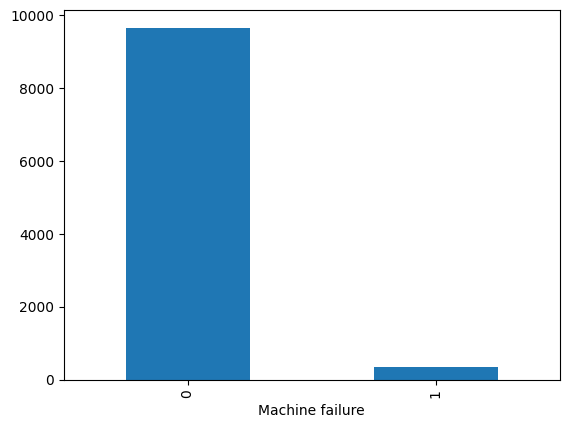

In [32]:


df["Machine failure"].value_counts().plot.bar()
plt.show()

In [33]:
df.nunique()

UDI                        10000
Product ID                 10000
Type                           3
Air temperature [K]           93
Process temperature [K]       82
Rotational speed [rpm]       941
Torque [Nm]                  577
Tool wear [min]              246
Machine failure                2
TWF                            2
HDF                            2
PWF                            2
OSF                            2
RNF                            2
dtype: int64

In [34]:
df1 = df.sample(frac=.1)

In [35]:
df1

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
9290,9291,L56470,L,298.2,309.0,1418,44.2,87,0,0,0,0,0,0
1801,1802,M16661,M,298.0,307.5,1427,43.6,101,0,0,0,0,0,0
5977,5978,L53157,L,300.6,310.7,1750,30.6,171,0,0,0,0,0,0
6900,6901,L54080,L,301.0,311.7,1670,31.3,150,0,0,0,0,0,0
5898,5899,L53078,L,301.0,310.7,1300,57.2,174,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6404,6405,M21264,M,300.2,309.7,1183,61.4,170,0,0,0,0,0,0
1142,1143,L48322,L,296.9,307.9,1423,43.9,149,0,0,0,0,0,0
171,172,L47351,L,298.2,308.1,1462,50.8,27,0,0,0,0,0,0
6324,6325,M21184,M,300.7,310.1,1367,52.6,167,0,0,0,0,0,0


In [36]:
df1.columns

Index(['UDI', 'Product ID', 'Type', 'Air temperature [K]',
       'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
       'Tool wear [min]', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF',
       'RNF'],
      dtype='object')

In [37]:
df1 = df1.drop(["UDI", 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'], axis=1).select_dtypes(include='number')
df1.head()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure
9290,298.2,309.0,1418,44.2,87,0
1801,298.0,307.5,1427,43.6,101,0
5977,300.6,310.7,1750,30.6,171,0
6900,301.0,311.7,1670,31.3,150,0
5898,301.0,310.7,1300,57.2,174,0


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

In [123]:
# sbn.pairplot(df1, hue="Machine failure", corner=True)
# plt.show()

In [ ]:
tracking_server_arn = "http://localhost:5000"
experiment_name = f"{project_prefix}-sm-pipelines-experiment"
run_name = f"run-{strftime('%d-%H-%S', gmtime())}"
project_prefix,tracking_server_arn, experiment_name, run_name

In [42]:
df.columns.to_list()

['UDI',
 'Product ID',
 'Type',
 'Air temperature [K]',
 'Process temperature [K]',
 'Rotational speed [rpm]',
 'Torque [Nm]',
 'Tool wear [min]',
 'Machine failure',
 'TWF',
 'HDF',
 'PWF',
 'OSF',
 'RNF']

In [ ]:
# @remote(keep_alive_period_in_seconds=3600, job_name_prefix=f"{project_prefix}-sm-btd-preprocess")
def preprocess(df, df_source: str, experiment_name: str):
    mlflow.set_tracking_uri(tracking_server_arn)
    mlflow.set_experiment(experiment_name=experiment_name)

    with mlflow.start_run(run_name=f"Preprocessing") as run:
        columns = ['Type', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Machine failure']
        cat_columns = ['Type']
        num_columns = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
        target_column = 'Machine failure'  
        df = df[columns]
        
        mlflow.log_input(
            mlflow.data.from_pandas(
                df,
                df_source,
                targets=target_column
            ),
            context="DataPreprocessing"
        )
        training_ratio = 0.8
        validation_ratio = 0.1
        test_ratio = 0.1

        X = df.drop(target_column, axis=1)
        y = df[target_column]

        print(f"Splitting data training ({training_ratio}), validation ({validation_ratio}), test ({test_ratio}) sets")
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, random_state=0, stratify=y)
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=validation_ratio/(validation_ratio + training_ratio), random_state=2, stratify=y_train)

        # Apply transformation
        transformer = ColumnTransformer(transformers=[('numeric', StandardScaler(), num_columns),
                                                    ('categorical', OneHotEncoder(), cat_columns)],
                                        remainder="passthrough")
        featurizer_model = transformer.fit(X_train)
        X_train = featurizer_model.transform(X_train)
        X_val = featurizer_model.transform(X_val)

        print(f"Shape of train feature after preprocessing: {X_train.shape}")
        print(f"Shape of validation features after preprocessing: {X_val.shape}")
        print(f"Shape of test feature after preprocessing : {X_test.shape}")
        
        y_train = y_train.values.reshape(-1)
        y_val = y_val.values.reshape(-1)

        print(f'Shape of train labels after preprocessing: {y_train.shape}')
        print(f'Shape of validation labels after preprocessing: {y_val.shape}')
        print(f'Shape of test labels after preprocessing: {y_test.shape}')

        model_file_path = "./opt/ml/model/sklearn_model.joblib"
        os.makedirs(os.path.dirname(model_file_path), exist_ok=True)
        joblib.dump(featurizer_model, model_file_path)

    return X_train, y_train, X_val, y_val, X_test, y_test, featurizer_model


In [44]:
X_train, y_train, X_val, y_val, X_test, y_test, featurizer_model = preprocess(df=df,
                                                                              df_source=dataset_url,
                                                                              experiment_name=experiment_name)

Splitting data training (0.8), validation (0.1), test (0.1) sets
Shape of train feature after preprocessing: (7999, 8)
Shape of validation features after preprocessing: (1001, 8)
Shape of test feature after preprocessing : (1000, 6)
Shape of train labels after preprocessing: (7999,)
Shape of validation labels after preprocessing: (1001,)
Shape of test labels after preprocessing: (1000,)


In [46]:
pd.DataFrame(X_train).head(10)

,0,1,2,3,4,5,6,7
0,0.647088,0.467287,-0.191472,0.720195,-0.536976,0.0,1.0,0.0
1,-0.149803,-0.607399,-0.353343,-0.002390,0.230714,0.0,1.0,0.0
2,2.091452,2.280819,1.125822,-1.186626,-0.474308,0.0,1.0,0.0
3,-1.893001,-1.883589,-0.130072,-0.353647,-1.100993,0.0,1.0,0.0
4,1.892229,1.944980,0.310886,-0.484113,-0.615312,0.0,0.0,1.0
5,-1.345139,-1.144742,-1.508765,2.065005,0.168045,0.0,1.0,0.0
6,-0.099997,-0.607399,-1.023153,1.673605,-1.586675,0.0,0.0,1.0
7,-0.647860,-0.002889,-0.107745,-0.193072,1.405749,0.0,0.0,1.0
8,0.497671,0.064279,0.109943,-0.745047,-1.696345,0.0,1.0,0.0
9,-0.896888,-1.346246,0.294141,-0.634652,-1.194996,0.0,0.0,1.0


In [ ]:
# @remote(keep_alive_period_in_seconds=3600, job_name_prefix=f"{project_prefix}-sm-btd-train")
def train(X_train,
          y_train,
          X_val,
          y_val,
          eta=0.1,
          max_depth=2,
          gamma=0.0,
          min_child_weight=1,
          verbosity=0,
          objective='binary:logistic',
          eval_metric='auc',
          num_boost_round=5):
    print('Train features shape: {}'.format(X_train.shape))
    print('Train labels shape: {}'.format(y_train.shape))
    print('Validation features shape: {}'.format(X_val.shape))
    print('Validation labels shape: {}'.format(y_val.shape))   

    mlflow.set_tracking_uri(tracking_server_arn)
    mlflow.set_experiment(experiment_name)

    with mlflow.start_run(run_name="Training") as run:
        mlflow.autolog()
        dtrain = xgboost.DMatrix(X_train, label=y_train)
        dval = xgboost.DMatrix(X_val, label=y_val)
        watchlist = [(dtrain, "train"), (dval, "validation")]

        print("")
        print(f"==Starting training with max_depth {max_depth}==")

        param_dict = {
            "max_depth": max_depth,
            "eta": eta,
            "gamma": gamma,
            "min_child_weight": min_child_weight,
            "verbosity": verbosity,
            "objective": objective,
            "eval_metric": eval_metric
        }

        xgb = xgboost.train(
            params=param_dict,
            dtrain=dtrain,
            evals=watchlist,
            num_boost_round=num_boost_round
        )
        predictions = xgb.predict(dval)
        print("Metrics for validation set")
        print("")
        print(pd.crosstab(index=y_val, columns=np.round(predictions),
                        rownames=["Actuals"], colnames=["Predictions"], margins=True))
        rounded_predict = np.round(predictions)
        val_accuracy = accuracy_score(y_val, rounded_predict)
        val_precision = precision_score(y_val, rounded_predict)
        val_recall = recall_score(y_val, rounded_predict)

        print("Accuracy Model A: %.2f%%" % (val_accuracy * 100.0))            
        print("Precision Model A: %.2f" % (val_precision))
        print("Recall Model A: %.2f" % (val_recall))

        mlflow.log_metric("Accuracy Model A", val_accuracy * 100.0)
        mlflow.log_metric("Precision Model A", val_precision)
        mlflow.log_metric("Recall Model A", val_recall)

        from sklearn.metrics import roc_auc_score

        val_auc = roc_auc_score(y_val, predictions)
        print("Validation AUC A: %.2f" % (val_auc))
        mlflow.log_metric("Validation AUC A", val_auc)

        model_file_path = "./opt/ml/model/xgboost_model.bin"
        os.makedirs(os.path.dirname(model_file_path), exist_ok=True)
        xgb.save_model(model_file_path)

    return xgb


In [48]:
eta=0.3
max_depth=8

booster = train(X_train, y_train, X_val, y_val,
              eta=eta, 
              max_depth=max_depth)

Train features shape: (7999, 8)
Train labels shape: (7999,)
Validation features shape: (1001, 8)
Validation labels shape: (1001,)

==Starting training with max_depth 8==
[0]	train-auc:0.96284	validation-auc:0.96190
[1]	train-auc:0.97833	validation-auc:0.99224
[2]	train-auc:0.98293	validation-auc:0.99267
[3]	train-auc:0.98492	validation-auc:0.99261
[4]	train-auc:0.98616	validation-auc:0.99317
Metrics for validation set

Predictions  0.0  1.0   All
Actuals                    
0            964    3   967
1              6   28    34
All          970   31  1001
Accuracy Model A: 99.10%
Precision Model A: 0.90
Recall Model A: 0.82
Validation AUC A: 0.99


In [ ]:
# @remote(keep_alive_period_in_seconds=600, job_name_prefix=f"{project_prefix}-sm-btd-test")
def test(featurizer_model, booster, X_test, y_test):

    mlflow.start_run(run_name=f"Testing")
    mlflow.autolog()
    X_test = featurizer_model.transform(X_test)
    y_test = y_test.values.reshape(-1)

    dtest = xgboost.DMatrix(X_test, label=y_test)
    test_predictions = booster.predict(dtest)
    
    print ("===Metrics for Test Set===")
    print('')
    print (pd.crosstab(index=y_test, columns=np.round(test_predictions), 
                                     rownames=['Actuals'], 
                                     colnames=['Predictions'], 
                                     margins=True)
          )
    print('')

    rounded_predict = np.round(test_predictions)

    accuracy = accuracy_score(y_test, rounded_predict)
    precision = precision_score(y_test, rounded_predict)
    recall = recall_score(y_test, rounded_predict)
    
    print('')
    print("Accuracy Model A: %.2f%%" % (accuracy * 100.0))
    print("Precision Model A: %.2f" % (precision))
    print("Recall Model A: %.2f" % (recall))
    
    mlflow.log_metric("Accuracy Model A", accuracy * 100.0)
    mlflow.log_metric("Precision Model A", precision)
    mlflow.log_metric("Recall Model A", recall)

    from sklearn.metrics import roc_auc_score

    auc = roc_auc_score(y_test, test_predictions)
    
    print("AUC A: %.2f" % (auc))
    mlflow.log_metric("AUC A",auc)
    
    mlflow.end_run()

In [52]:
test(featurizer_model, booster, X_test, y_test)

===Metrics for Test Set===

Predictions  0.0  1.0   All
Actuals                    
0            961    5   966
1             10   24    34
All          971   29  1000


Accuracy Model A: 98.50%
Precision Model A: 0.83
Recall Model A: 0.71
AUC A: 0.94


In [ ]:
job_name_prefix=f"{project_prefix}-sm-btd-preprocess"
job_name_prefix
search_training = sm_client.search(
    Resource="TrainingJob",
    SearchExpression={
        "Filters": [
            {
                "Name": "TrainingJobName",
                "Operator": "Contains",
                'Value': job_name_prefix
            }
        ]
    },
    SortBy='CreationTime',
    SortOrder='Descending',
    MaxResults=1
)
# search_training

In [ ]:
S3Downloader.download(search_training["Results"][0]["TrainingJob"]["ModelArtifacts"]["S3ModelArtifacts"], "sklearn_model/")
subprocess.call(["tar", "-xvzf", "sklearn_model/model.tar.gz", "-C", "sklearn_model/"])
# subprocess.call(["rm", "sklearn_model/model.tar.gz"])

INFO:botocore.credentials:Found credentials in environment variables.


['sklearn-model/model.tar.gz']

In [ ]:
featurizer = joblib.load('sklearn_model/sklearn_model.joblib')
# booster = xgboost.Booster()
# xgbooster = booster.load_model('xgboost_model/xgboost_model.bin')
feature_columns_names = ['Type', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']

In [ ]:
class SklearnRequestTranslator(CustomPayloadTranslator):
    print("Inside ")
    def serialize_payload_to_bytes(self, payload: object) -> bytes:
        print("Received Payload:", payload)
        return payload.encode("utf-8")
    
    def deserialize_payload_from_stream(self, stream) -> pd.DataFrame:
        print("In Deserialize Stream:", stream)
        df = pd.read_csv(io.BytesIO(stream.read()), header=None)
        print("In Deserialize Created dataframe:", df)
        df.columns = feature_columns_names
        print("In Deserialize Created dataframe with column names:", df)
        return df
    
class SklearnModelSpec(InferenceSpec):
    print("Inference Specification : ")
    def invoke(self, input_object: object, model: object):
        print("Inference Specification: for input object:", input_object)
        features = model.transform(input_object)
        print("Inference Specification: created features:", features)
        return features
    def load(self, model_dir):
        print("Inference Specification: loading model from directory:", model_dir)
        model_path = model_dir + '/sklearn_model.joblib'
        print("Inference Specification: model_path: ", model_path)
        model = joblib.load(model_path)
        print("Inference Specification: loaded model: ", model)
        return model
    
schema_builder = SchemaBuilder(
    sample_input="L,298.4,308.2,1582,70.7,216",
    sample_output=np.array([0.647088,0.467287,-0.191472,0.720195,-0.536976,0.0,1.0,0.0]),
    input_translator=SklearnRequestTranslator(),
)

model_file_path = "sklearn_model/sklearn_model.joblib"
os.makedirs(os.path.dirname(model_file_path), exist_ok=True)
bucket_prefix = f"s3://{bucket_name}/{project_prefix}"

model_builder = ModelBuilder(
    model_path="sklearn_model/",
    name='sklearn-featurizer',
    dependencies={"requirements": "requirements_inference.txt"},
    image_uri=get_image_uri(framework="sklearn", region=region_name, version="1.2-1"),
    schema_builder=schema_builder,
    model_server=ModelServer.TORCHSERVE,
    inference_spec=SklearnModelSpec(),
    role_arn=role,
    s3_model_data_url=bucket_prefix
)

built_sklearn_model = model_builder.build()

INFO:sagemaker.image_uris:Defaulting to only available Python version: py3
INFO:sagemaker.image_uris:Defaulting to only supported image scope: cpu.
INFO:botocore.credentials:Found credentials in environment variables.


Inside 
Inference Specification : 
Received Payload: L,298.4,308.2,1582,70.7,216
In Deserialize Stream: <_io.BytesIO object at 0x00000154CBFD3F60>
In Deserialize Created dataframe:    0      1      2     3     4    5
0  L  298.4  308.2  1582  70.7  216
In Deserialize Created dataframe with column names:   Type  Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
0    L                298.4                    308.2                    1582   

   Torque [Nm]  Tool wear [min]  
0         70.7              216  
sagemaker.config INFO - Fetched defaults config from location: c:\pm_projects\Sagemaker.CICD.Pipeline\test


ModelBuilder: INFO:     ModelBuilder will collect telemetry to help us better understand our user's needs, diagnose issues, and deliver additional features. To opt out of telemetry, please disable via TelemetryOptOut in intelligent defaults. See https://sagemaker.readthedocs.io/en/stable/overview.html#configuring-and-using-defaults-with-the-sagemaker-python-sdk for more info.


[8/7/2025 1:32:31 PM] INFO     Either inference spec or model is provided. ModelBuilder is not ]8;id=926015;file://c:\.venvs\mlflow_venv\lib\site-packages\sagemaker\serve\builder\model_builder.py\model_builder.py]8;;\:]8;id=261238;file://c:\.venvs\mlflow_venv\lib\site-packages\sagemaker\serve\builder\model_builder.py#845\845]8;;\
                               handling MLflow model input                                                         

INFO:sagemaker_core.main.utils:Either inference spec or model is provided. ModelBuilder is not handling MLflow model input


                      INFO     Skipping auto detection as the image uri is provided            ]8;id=754415;file://c:\.venvs\mlflow_venv\lib\site-packages\sagemaker\serve\builder\model_builder.py\model_builder.py]8;;\:]8;id=39041;file://c:\.venvs\mlflow_venv\lib\site-packages\sagemaker\serve\builder\model_builder.py#391\391]8;;\
                               683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-scikit-l                     
                               earn:1.2-1-cpu-py3                                                                  

INFO:sagemaker_core.main.utils:Skipping auto detection as the image uri is provided 683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-scikit-learn:1.2-1-cpu-py3
ModelBuilder: DEBUG:     Packaging provided requirements.txt from requirements_inference.txt
ModelBuilder: DEBUG:     Uploading the model resources to bucket=sagemaker07272025, key_prefix=amzn/sagemaker-scikit-learn-2025-08-07-08-02-31-758.
Uploading model artifacts: 100%|█████████████████████████| 14695/14695 [00:01<00:00, 7535.29bytes/s]
ModelBuilder: DEBUG:     Model resources uploaded to: s3://sagemaker07272025/amzn/sagemaker-scikit-learn-2025-08-07-08-02-31-758/serve.tar.gz
ModelBuilder: DEBUG:     ModelBuilder metrics emitted.


In [ ]:
class RequestTranslater(CustomPayloadTranslator):
    print("Inside RequestTranslater for XGBoost")
    def serialize_payload_to_bytes(self, payload):
        print("Inside RequestTranslater for XGBoost: payload: ", payload)
        buffer = io.BytesIO()
        print("Inside RequestTranslater for XGBoost, buffer", buffer)
        np.save(buffer, payload)
        print("Inside RequestTranslater for XGBoost: np array:", buffer.getvalue())
        return buffer.getvalue()
    
    def deserialize_payload_from_stream(self, stream):
        print("Inside RequestTranslater for XGBoost: inside deserialize stream:", stream)
        np_array = np.load(io.BytesIO(stream.read())).reshape((1, -1))
        print("Inside RequestTranslater for XGBoost: np array:", np_array)
        dmatrix = xgboost.DMatrix(np_array)
        print("Inside RequestTranslater for XGBoost: dmatrix:", dmatrix)
        return dmatrix
    
schema_builder = SchemaBuilder(
    sample_input=np.array([0.647088,0.467287,-0.191472,0.720195,-0.536976,0.0,1.0,0.0]),
    sample_output=np.array([0.15388985]),
    input_translator=RequestTranslater()
)

class XGBoostModelSpec(InferenceSpec):
    print("XGBoostModelSpec :")
    def invoke(self, input_object: object, model: object):
        print("XGBoostModelSpec inside invoke: input_object:", input_object, "model:", model)
        features = model.predict(input_object)
        print("XGBoostModelSpec inside invoke: features:", features)
        return features

    def load(self, model_dir: str):
        import xgboost
        print("XGBoostModelSpec inside load: model_dir:", model_dir)
        model_path = model_dir+'/xgboost_model.bin'
        print("XGBoost ModelSpec inside load: model_path:", model_path)
        booster = xgboost.Booster()
        model = booster.load_model(model_path)
        print("XGBoostModelSpec : model:", model)
        return model
model_file_path = "xgboost_model/xgboost_model.bin"
os.makedirs(os.path.dirname(model_file_path), exist_ok=True)
booster.save_model(model_file_path)

bucket_prefix = f"s3://{bucket_name}/{project_prefix}"

model_builder = ModelBuilder(
    model=booster,
    model_path="xgboost_model/",
    dependencies={"requirements": "requirements_inference.txt"},
    schema_builder=schema_builder,
    role_arn=role,
    s3_model_data_url=bucket_prefix,
    image_uri=get_image_uri(framework="xgboost", region=region_name, version="1.7-1")
)

built_xgboost_model = model_builder.build()

Inside RequestTranslater for XGBoost
Inside RequestTranslater for XGBoost: payload:  [ 0.647088  0.467287 -0.191472  0.720195 -0.536976  0.        1.
  0.      ]
Inside RequestTranslater for XGBoost, buffer <_io.BytesIO object at 0x00000154D8A43560>
Inside RequestTranslater for XGBoost: np array: b"\x93NUMPY\x01\x00v\x00{'descr': '<f8', 'fortran_order': False, 'shape': (8,), }                                                            \n\x1fJ\xb4\xe4\xf1\xb4\xe4?\x14$\xb6\xbb\x07\xe8\xdd?]\xc3\x0c\x8d'\x82\xc8\xbf]\xc4wb\xd6\x0b\xe7?\xa7\x94\xd7J\xe8.\xe1\xbf\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0?\x00\x00\x00\x00\x00\x00\x00\x00"
Inside RequestTranslater for XGBoost: inside deserialize stream: <_io.BytesIO object at 0x00000154D8A43560>
Inside RequestTranslater for XGBoost: np array: [[ 0.647088  0.467287 -0.191472  0.720195 -0.536976  0.        1.
   0.      ]]
Inside RequestTranslater for XGBoost: dmatrix: <xgboost.core.DMatrix object at 0x00000154D8AF02B0>
XGBoo

INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:botocore.credentials:Found credentials in environment variables.
ModelBuilder: INFO:     ModelBuilder will collect telemetry to help us better understand our user's needs, diagnose issues, and deliver additional features. To opt out of telemetry, please disable via TelemetryOptOut in intelligent defaults. See https://sagemaker.readthedocs.io/en/stable/overview.html#configuring-and-using-defaults-with-the-sagemaker-python-sdk for more info.


[8/7/2025 1:34:33 PM] INFO     Either inference spec or model is provided. ModelBuilder is not ]8;id=104905;file://c:\.venvs\mlflow_venv\lib\site-packages\sagemaker\serve\builder\model_builder.py\model_builder.py]8;;\:]8;id=631408;file://c:\.venvs\mlflow_venv\lib\site-packages\sagemaker\serve\builder\model_builder.py#845\845]8;;\
                               handling MLflow model input                                                         

INFO:sagemaker_core.main.utils:Either inference spec or model is provided. ModelBuilder is not handling MLflow model input


                      INFO     Skipping auto detection as the image uri is provided            ]8;id=863948;file://c:\.venvs\mlflow_venv\lib\site-packages\sagemaker\serve\builder\model_builder.py\model_builder.py]8;;\:]8;id=211007;file://c:\.venvs\mlflow_venv\lib\site-packages\sagemaker\serve\builder\model_builder.py#391\391]8;;\
                               683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:                     
                               1.7-1                                                                               

INFO:sagemaker_core.main.utils:Skipping auto detection as the image uri is provided 683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.7-1
ModelBuilder: DEBUG:     Packaging provided requirements.txt from requirements_inference.txt
ModelBuilder: DEBUG:     Uploading the model resources to bucket=sagemaker07272025, key_prefix=amzn/sagemaker-xgboost-2025-08-07-08-04-33-787.
Uploading model artifacts: 100%|████████████████████████| 54354/54354 [00:02<00:00, 25409.98bytes/s]
ModelBuilder: DEBUG:     Model resources uploaded to: s3://sagemaker07272025/amzn/sagemaker-xgboost-2025-08-07-08-04-33-787/serve.tar.gz
ModelBuilder: DEBUG:     ModelBuilder metrics emitted.


In [ ]:
pipeline_model_name = unique_name_from_base(f"{project_prefix}-sm-btd-endpoint")
endpoint_name = unique_name_from_base(f"{project_prefix}-sm-btd-endpoint")
endpoint_name1 = unique_name_from_base(f"{project_prefix}-sm-btd-endpoint")

pipeline_model = PipelineModel(
    name=pipeline_model_name,
    role=role,
    models=[
        built_sklearn_model,
        built_xgboost_model
    ]
)

In [ ]:
built_sklearn_model, built_xgboost_model, pipeline_model_name, endpoint_name, endpoint_name1

In [77]:
pipeline_model.deploy(
    initial_instance_count=1,
    instance_type='ml.m5.2xlarge',
    endpoint_name=endpoint_name,
    wait=False
)

INFO:botocore.credentials:Found credentials in environment variables.
INFO:sagemaker:Creating model with name: amzn-sm-btd-endpoint-1754553885-c7e4
INFO:sagemaker:Creating endpoint-config with name amzn-sm-btd-endpoint-1754553893-aa1b
INFO:sagemaker:Creating endpoint with name amzn-sm-btd-endpoint-1754553893-aa1b


In [80]:
pipeline_model.deploy(
    initial_instance_count=1,
    instance_type='ml.m5.xlarge',
    endpoint_name=endpoint_name1,
    wait=False
)

INFO:sagemaker:Creating model with name: amzn-sm-btd-endpoint-1754553885-c7e4
INFO:sagemaker:Creating endpoint-config with name amzn-sm-btd-endpoint-1754553963-ccdb
INFO:sagemaker:Creating endpoint with name amzn-sm-btd-endpoint-1754553963-ccdb


In [81]:
!python test.py amzn-sm-btd-endpoint-1754553893-aa1b

sagemaker.config INFO - Not applying SDK defaults from location: C:\ProgramData\sagemaker\sagemaker\config.yaml
sagemaker.config INFO - Fetched defaults config from location: c:\pm_projects\Sagemaker.CICD.Pipeline\test
Inference payload: L,298.4,308.2,1582,70.7,216
Inference result: [0.8878407]
Inference payload: M,298.4,308.2,1582,30.2,214
Inference result: [0.12801738]


# List package group names

In [20]:
import boto3
import os

project_prefix = "amzn"
bucket_name = "sagemaker07272025"
bucket_prefix = f"{bucket_name}/{project_prefix}"
SM_DIST_IMAGE=f"public.ecr.aws/sagemaker/sagemaker-distribution:1.11-gpu"
REGION = boto3.session.Session().region_name
REPO_NAME = f"{project_prefix}-sagemaker-distribution-prod"
ACCOUNT_ID = boto3.client('sts').get_caller_identity()['Account']
MY_REPO=f"{ACCOUNT_ID}.dkr.ecr.{REGION}.amazonaws.com/{REPO_NAME}:latest"

In [21]:
bucket_name, bucket_prefix

('sagemaker07272025', 'sagemaker07272025/amzn')

In [22]:
config_yaml = f"""
SchemaVersion: '1.0'
SageMaker:
  PythonSDK:
    Modules:
      RemoteFunction:
        # role arn is not required if in SageMaker Notebook instance or SageMaker Studio
        # Uncomment the following line and replace with the right execution role if in a local IDE
        # RoleArn: <replace the role arn here>
        S3RootUri: s3://{bucket_prefix}
        ImageUri: {MY_REPO}
        InstanceType: ml.m5.xlarge
        Dependencies: ./requirements.txt
        IncludeLocalWorkDir: true
        # PreExecutionCommands:
        # - "sudo chmod -R 777 /opt/ml/model"
        CustomFileFilter:
          IgnoreNamePatterns:
          - "data/*"
          - "models/*"
          - "*.ipynb"
          - "__pycache__"

"""

In [24]:
print(config_yaml)


SchemaVersion: '1.0'
SageMaker:
  PythonSDK:
    Modules:
      RemoteFunction:
        # role arn is not required if in SageMaker Notebook instance or SageMaker Studio
        # Uncomment the following line and replace with the right execution role if in a local IDE
        # RoleArn: <replace the role arn here>
        S3RootUri: s3://sagemaker07272025/amzn
        ImageUri: 395435558728.dkr.ecr.us-east-1.amazonaws.com/amzn-sagemaker-distribution-prod:latest
        InstanceType: ml.m5.xlarge
        Dependencies: ./requirements.txt
        IncludeLocalWorkDir: true
        # PreExecutionCommands:
        # - "sudo chmod -R 777 /opt/ml/model"
        CustomFileFilter:
          IgnoreNamePatterns:
          - "data/*"
          - "models/*"
          - "*.ipynb"
          - "__pycache__"




In [27]:
print(config_yaml, file=open("../pipeline-03/config.yaml", "w"))